## This notebook contains a **tutorial** followed by **Problem 3 of Homework 3**, both of which are based on PyTorch.

### To complete this problem, please upload this .ipynb (Notebook) file **to Google Colab.** (You'll need to use Colab because it supports GPU and has all the necessary packages pre-installed.) When you're finished, go to "File -> Download .ipynb" and submit your .ipynb notebook as a supplemental file.

### This notebook has instructions for several homework problems.  ***You must write your answers to these problems in your PDF submission file.*** Your Colab notebook will not be graded, so please make sure you transfer all deliverables (including plots and written work) to your PDF.  

In [ ]:
import torch
import numpy as np
import math

So far in CS 181, we've been using numpy and scikit-learn to write ML code. In this tutorial, we'll introduce you to **PyTorch**, the ML library of choice for industry and academia.

**Before working through this notebook, make sure that the runtime type is set to GPU.** Follow Edit -> Notebook settings -> and select GPU as the hardware accelerator.

# Tutorial: Getting to Know PyTorch - Key Concepts

### Why PyTorch?

PyTorch...
*   Provides flexible building blocks for building customizable models, including neural network layers, activation functions, and optimization algorithms
*   Can automatically compute gradients, making backpropagation a breeze!
*   Can accelerate computation on GPUs

## Tensors

Tensors are the basic units of storage and computation in PyTorch. They are very similar to NumPy arrays, and follow the same syntax for indexing and for most arithmetic operations.


In [ ]:
# Basic tensor operations
x_tensor = torch.tensor([1, 2, 3, 4, 5])
y_tensor = torch.ones((2, 5))
prod = x_tensor * y_tensor[1,:]
print(prod, prod.shape) # Use .shape to view shape just as in NumPy

tensor([1., 2., 3., 4., 5.]) torch.Size([5])


In [ ]:
# Easy conversion between PyTorch and Numpy
x_numpy = np.array([1, 2, 3, 4, 5])
assert (x_tensor.numpy() == x_numpy).all()
assert (x_tensor == torch.from_numpy(x_numpy)).all()

What makes tensors **different** from NumPy arrays is:

1. They support GPU acceleration.
2. They contain additional information (accessed as attributes, which we will see later) which facilitate the easy building and training of neural networks, via **computation graphs** and **gradients**.

## A motivating example

To see the advantages of PyTorch in action, let's first take a look at how one might train a simple model using only NumPy:

In [ ]:
import numpy as np
import math

# Create 2000 random input and output data points
x = np.linspace(-math.pi, math.pi, 2000)
y = np.sin(x)

# Step 0 - Initialization: Initialize model parameters (randomly, in this example)
a = np.random.randn()
b = np.random.randn()
c = np.random.randn()
d = np.random.randn()

learning_rate = 1e-6
for t in range(2000):
    # Step 1 - Forward Pass: compute predicted y according to the following model:
    # y = a + b x + c x^2 + d x^3
    y_pred = a + b * x + c * x ** 2 + d * x ** 3

    # Step 2 - Compute Loss (MSE in this example)
    loss = np.square(y_pred - y).sum() # Sum across 2000 training points
    if t % 100 == 0:
        print(f'Epoch {t}: loss {loss}')

    # Step 3 - Differentiate: Use backprop (chain rule) to compute gradients
    # of the loss function with respect to a, b, c, d
    grad_y_pred = 2.0 * (y_pred - y)
    grad_a = grad_y_pred.sum() # Sum across 2000 training points
    grad_b = (grad_y_pred * x).sum()
    grad_c = (grad_y_pred * x ** 2).sum()
    grad_d = (grad_y_pred * x ** 3).sum()

    # Step 4 - Optimize: Update weights (vanilla GD in this example)
    a -= learning_rate * grad_a
    b -= learning_rate * grad_b
    c -= learning_rate * grad_c
    d -= learning_rate * grad_d

print(f'Result: y = {a} + {b} x + {c} x^2 + {d} x^3')

# From: https://pytorch.org/tutorials/beginner/pytorch_with_examples.html

Epoch 0: loss 96741.02537901758
Epoch 100: loss 899.4745411548233
Epoch 200: loss 597.8871215642682
Epoch 300: loss 398.4282794106342
Epoch 400: loss 266.5102014511127
Epoch 500: loss 179.2610361360413
Epoch 600: loss 121.55455322955524
Epoch 700: loss 83.38696371826302
Epoch 800: loss 58.142152006220854
Epoch 900: loss 41.4444263386048
Epoch 1000: loss 30.399804979958827
Epoch 1100: loss 23.094249474113354
Epoch 1200: loss 18.261823834484098
Epoch 1300: loss 15.065231170635537
Epoch 1400: loss 12.950669737056435
Epoch 1500: loss 11.551839662050646
Epoch 1600: loss 10.626455488753315
Epoch 1700: loss 10.014256668274339
Epoch 1800: loss 9.609236038217087
Epoch 1900: loss 9.341271687507636
Result: y = -0.0020581430278558306 + 0.8747825804701485 x + 0.00035506391995293975 x^2 + -0.09589666907640013 x^3


Each step involved in training a model is coded very explicitly in this example:
0. Initialization: Initialize model parameters (i.e. weights)
1. Forward Pass: Compute predictions
2. Compute Loss
3. Differentiate: Compute gradients via backpropagation (chain rule)
4. Optimize: Update weights using gradients

Notice how:
- Every model parameter is stored as a variable, which contains a weight value to be continuously updated through training
- The calculation of the gradient of the loss function with respect to the model parameters is coded explicitly and thus *model dependent*
<!-- - The gradient of the loss function needs to be computed with respect to the model parameters explicitly using the chain rule -->
- Each model parameter's gradient is used to update the weight value according to a particular update rule which is also explicitly implemented - in this example, standard gradient descent (GD).

Steps 0 and 1 might not be so difficult using a basic package such as NumPy; however, one could imagine that steps 2 and 3 would quickly become too burdensome to implement manually for models with more parameters, both because of 1) the large number of parameters and 2) the fact that the explicit implementation of the chain rule and update rule will look different every time depending on the the model structure and optimization algorithm.

This is where PyTorch's **automatic differentiation** engine, **Autograd**, is useful. As the name implies, PyTorch can take care of computing gradients and applying optimization update rules automatically under the hood, such that the code we write to invoke these two operaations will look (very nearly) the same across all models.

## Computation Graphs and Autograd

<!-- Old paragraphs, commented out to preserve in case we want to bring back language -->
<!-- Autograd, PyTorch's automatic differentiation engine, is one of the best things that PyTorch has to offer when it comes to training neural networks! Recall that in order to compute gradients for weights in a neural network, you have to backpropagate errors at each node. This is computationally intensive even for a one or two layers and would be a nightmare to implement manually for very deep networks. -->
<!-- PyTorch tensors can keep track of a *computation graph* whenever operations are performed on/between tensors. Autograd performs backprop on this computation graph, so all the steps to compute the gradient are abstracted away. To perform a gradient step update, you simply have to call built-in PyTorch functions that computes the derivative of the loss and (if you're using gradient descent) takes a step toward a gradient of zero. -->

To implement automatic differentiation, PyTorch keeps track of a **computation graph** which logs every operation used to construct a certain output or mathematical expression (more on computation graphs in the [Appendix](#Appendix)). Computation graphs are created automatically whenever mathematical operations are performed using tensors as inputs. Using this graph, **Autograd** can perform backpropagation by repeated applications of the chain rule, and all of these differentiation steps are abstracted away from the user. To perform weight updates, we simply call built-in PyTorch optimizer functions which implement different update rules using the gradients computed during backpropagation.

As we work through the following example, keep in mind that computation graphs in PyTorch are *implicitly* constructed when one builds mathematical expressions. That is, one will never have to write code expressly for the purpose of building such a graph; rather, the computation graph will be assembled automatically using whichever Tensors or operations are appropriately "earmarked" for tracking (see `requires_grad` below).

Let's start with a simple example of autograd. (Original example from https://pytorch.org/tutorials/beginner/nlp/pytorch_tutorial.html.)


In [ ]:
# Create tensors
x = torch.randn(2, 2)
y = torch.randn(2, 2)
print('x:', x)
print('y:', y)

x: tensor([[ 0.4836,  0.3513],
        [-0.6752,  0.6740]])
y: tensor([[-0.0536, -1.9210],
        [-0.5528,  0.0268]])


Tensors have a ```requires_grad``` field. When ```requires_grad == True``` for a certain tensor, any subsequent operations that this tensor is an input to will be incorporated into a computation graph. Autograd will then be able to automatically compute partial derivatives *with respect to this tensor*. (Derivative of what function? More on that [later](#step5).) 

For any tensors which are the outputs of operations tracked in the computation graph, the ```grad_fn``` attribute will indicate the operation that created the tensor, represented as a `Function` object. (It is these `Function`s which encode the computation graph DAG [Directed Acyclic Graph].)

**Important: If some starting tensors have requires_grad = True, then every tensor resulting from operations of those starting tensors will also have requires_grad = True.**



In [ ]:
# By default, user created Tensors have ``requires_grad=False``
print('x and y requires_grad:', x.requires_grad, y.requires_grad)
z = x + y
# So you can't backprop through z
print('z grad_fn:', z.grad_fn)

x and y requires_grad: False False
z grad_fn: None


In [ ]:
# ``.requires_grad_( ... )`` changes an existing Tensor's ``requires_grad`` flag in-place.
# The input flag defaults to ``True`` if not given.
x = x.requires_grad_()
y = y.requires_grad_()
# z contains enough information to compute gradients, as we saw above
z = x + y
print('z grad_fn:', z.grad_fn)
# If any input to an operation has ``requires_grad=True``, so will the output
print('z requires_grad:', z.requires_grad)

z grad_fn: <AddBackward0 object at 0x7fb234039990>
z requires_grad: True


We can also detach a tensor from its computation graph:

In [ ]:
# Now z has the computation history that relates itself to x and y
# Can we just take its values, and **detach** it from its history?
new_z = z.detach()

# ... does new_z have information to backprop to x and y?
# NO!
print('new_z grad_fn:', new_z.grad_fn)
# And how could it? ``z.detach()`` returns a tensor that shares the same storage as ``z``, but with the computation history forgotten.
# It doesn't know anything about how it was computed.
# In essence, we have broken the Tensor away from its past history

new_z grad_fn: None


Now that we've been introduced to `requires_grad`, `grad_fn` and the computation graph....

#### Question: Where should I actually set requires_grad to make everything work?
#### Short Answer: In any tensors which represent model parameters or weights.

Long Answer:

- If you are initializing a parameter(s)/weight(s) by creating an individual tensor(s) manually, you have to set its `requires_grad = True` argument. 
- If you are initializing a parameter(s)/weight(s) by using built-in PyTorch methods from packages such as nn.Layer and nn.Parameter, the internally initialized tensors should already have `requires_grad` set to `True`.


## GPU Acceleration

GPUs are built for parallel processing — they can handle thousands of operations at the same time — which makes them great for computationally-intensive neural nets.

In [ ]:
# To run tensor operations on GPU in Colab, go to Edit -> Notebook settings -> and select GPU as the hardware accelerator.
# If GPU is enabled, the following assertion should pass.
assert torch.cuda.is_available()

In [ ]:
# When creating a tensor, set its device to use CUDA (a GPU parallel computing platform), as shown below.
# What this means is that we are telling PyTorch to physically initialize the relevant 
# variable in GPU memory.
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
x = torch.rand(5, 5, device=device)
y = torch.rand(5, 5, device=device)
x * y

tensor([[0.2389, 0.5907, 0.3268, 0.3197, 0.1027],
        [0.0764, 0.1218, 0.2003, 0.2460, 0.1116],
        [0.1957, 0.5576, 0.4075, 0.4675, 0.5793],
        [0.1489, 0.1124, 0.6500, 0.0438, 0.5834],
        [0.1487, 0.3355, 0.0060, 0.0075, 0.0170]], device='cuda:0')

## Defining a Model

* The ```nn``` package defines basic neural network layers (or Modules, in PyTorch-speak) as well as common loss functions. Modules take a tensor as input, apply some computation/function to it, and then output the new tensor. 

* The ```optim``` package defines common optimization algorithms such as Adam, RMSProp, and AdaGrad. These algorithms are all variations of stochastic (randomized) gradient descent, and they may differ in terms of how the gradient steps are taken and how the learning rate adapts over epochs. (More details here: https://pytorch.org/docs/stable/optim.html.)

### Example: Cubic Model
Let's say we want to predict y's modeled as ```ax + bx^2 + cx^3```, and our goal is to learn the weights ```a```, ```b```, and ```c```. (Original example from https://pytorch.org/tutorials/beginner/pytorch_with_examples.html#id21.) 

### Step 1: Generate Data

In [ ]:
# Create Tensors to hold input and outputs.
x = torch.linspace(-math.pi, math.pi, 2000)
y = torch.sin(x)

# Prepare the input tensor (x, x^2, x^3).
p = torch.tensor([1, 2, 3])
xx = x.unsqueeze(-1).pow(p) 
print(xx.shape)
# Unsqueeze inserts a dimension of size one at the specified location; the tensor
# is reshaped to (2000, 1). Since p is a tensor, pow is applied according to
# broadcasting rules; xx has a final shape of (2000, 3). See documentation for 
# more on broadcasting; PyTorch supports NumPy broadcasting semantics.

torch.Size([2000, 3])


<a name="step2"></a>

### Step 2: Define Model (using nn package)

In [ ]:
# Use the nn package to define our model as a sequence of layers.
# nn.Sequential is a Module which contains other Modules, and applies them in sequence to produce its output.
# nn.Linear computes the 3 input features (x, x^2, and x^3) into 1 output feature using a linear function,
# holding internal tensors for its weight and bias.
# nn.Flatten flattens the output of the linear layer to a 1D tensor to match the shape of y.
# In this case, the first dim it flattens is at index 0, and the last dim it flattens is at index 1.

model = torch.nn.Sequential(
    torch.nn.Linear(3, 1),
    torch.nn.Flatten(0, 1)
)

### Step 3: Define Loss Function (using nn package)

In [ ]:
# In this case, we will use Mean Squared Error. 
# You can either implement loss functions manually, or
# you can use PyTorch's implementations of commonly-used loss functions.
loss_fn = torch.nn.MSELoss(reduction='sum')

### Step 4: Define Optimizer (using optim package)

Use the optim package to define an Optimizer that will update the weights of the model for us. Here we will use RMSprop; the optim package contains many other optimization algorithms. The first argument to the RMSprop constructor tells the optimizer which Tensors it should update.

In general, what distinguishes different optimizers is the way that they use gradients to define an update rule or scheme for their model weights. It follows then that any optimizer will always need the weights to be updated, and their corresponding gradients. In PyTorch, both of these quantities are stored together under model parameter variables. In particular, if `var` is a model weight, `var.grad` will contain a gradient with respect to `var` after backpropagation is performed. More in the next code cell.

In [ ]:
learning_rate = 1e-3
optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)

<a name="step5"></a>

### Step 5: Train the Model

Every time you train a model, be sure to include these 3 short but important lines that do much of the heavy lifting for you!

1.   `optimizer.zero_grad()`: Zeroes out gradients from previous iterations. Otherwise, over the epochs, gradients will accumulate (sum) in `parameter.grad` of each `parameter` which was passed to the optimizer as an argument.
2.   `loss.backward()`: Does all the backpropagation in one fell swoop (takes the derivative of the loss). We call `.backward()` on the loss tensor, which has the effect of taking the partial derivative of the loss with respect to the model parameters. For a model parameter (weight) `w`, dloss/dw will be stored in `w.grad` after `loss.backward()`.
3. `optimizer.step()`: Based on the previously specified optimizer algorithm and learning rate, updates the parameters in the direction of the gradient. This represents one iteration of the weight update rule.




In [ ]:
num_epochs = 2000
for epoch in range(num_epochs):

    # Forward pass: compute predicted y by passing x to the model.
    y_pred = model(xx)

    # Compute and print loss.
    loss = loss_fn(y_pred, y)
    if epoch % 100 == 99:
        print(epoch, loss.item())

    # Before the backward pass, zero all the gradients for the variables it will update
    # (these are the learnable weights of the model). This is because by defaults, 
    # gradients from previous iterations won't be overwritten. 
    optimizer.zero_grad()

    # Backward pass: compute gradient of the loss with respect to model parameters
    loss.backward()
    # After taking the backward pass, you can see the computed gradient for each parameter
    if epoch % 100 == 99:
      # The model implicitly stores the parameters, as shown below:
      for i, param in enumerate(model.parameters()):
        # param.grad refers to d_loss/d_parameter
        print('parameter', i, 'gradient', param.grad)

    # Calling the step function on an Optimizer makes an update to its parameters
    optimizer.step()

linear_layer = model[0]
print(f'Result: y = {linear_layer.bias.item()} + {linear_layer.weight[:, 0].item()} x + {linear_layer.weight[:, 1].item()} x^2 + {linear_layer.weight[:, 2].item()} x^3')

99 21216.859375
parameter 0 gradient tensor([[1.9800e+04, 1.0464e+02, 1.5073e+05]])
parameter 1 gradient tensor([-199.4221])
199 9220.1669921875
parameter 0 gradient tensor([[1.1973e+04, 5.5177e+01, 9.6741e+04]])
parameter 1 gradient tensor([-114.2843])
299 3665.81689453125
parameter 0 gradient tensor([[6.0572e+03, 2.1876e+01, 5.5883e+04]])
parameter 1 gradient tensor([-49.4486])
399 1527.0855712890625
parameter 0 gradient tensor([[1.7839e+03, 5.5911e+00, 2.6271e+04]])
parameter 1 gradient tensor([-13.0027])
499 986.39306640625
parameter 0 gradient tensor([[-6.5597e+02,  6.1726e-01,  9.1305e+03]])
parameter 1 gradient tensor([-1.4426])
599 859.09423828125
parameter 0 gradient tensor([[-1.4664e+03,  1.8135e-02,  2.9492e+03]])
parameter 1 gradient tensor([-0.0371])
699 747.337890625
parameter 0 gradient tensor([[-1.5222e+03,  3.4702e-04,  1.6870e+03]])
parameter 1 gradient tensor([-3.6716e-05])
799 620.6927490234375
parameter 0 gradient tensor([[-1438.0822,   180.5932,  1171.3955]])
para

# **Problem 3, Part 1: PyTorch Concept Questions**

*Write up your answers to these problems in your PDF submission.  Any work included in your Colab notebook will not be graded.*

These questions are intended to be a straightforward check on some fundamental PyTorch concepts. You are encouraged to use the PyTorch documentation and any other online resources to answer these questions.  Please write no more than 3 sentences to answer each of the below questions.

# Problem 3.1
Where are gradients stored in PyTorch and how can they be accessed?

A: It follows then that any optimizer will always need the weights to be updated, and their corresponding gradients. In PyTorch, both of these quantities are stored together under model parameter variables. In particular, if var is a model weight, var.grad will contain a gradient with respect to var after backpropagation is performed

# Problem 3.2
In the model defined in [Step 2](#step2) in the tutorial section, how many weights does the model have, and which layer do they come from?

A: 3 weights, from the linear/fully-connected layer.

# Problem 3.3
Conceptually, what is a fully-connected layer in a neural network, and how is it represented in PyTorch?

A: A layer where all nodes in previous layer are connected to nodes in current layer. To create a fully connected layer in PyTorch, we use the nn. Linear method. The first argument to this method is the number of nodes in the layer, and the second argument is the number of nodes in the following layer.

# **Problem 3, Part 2: Training a Neural Network on CIFAR-10**

In this part, you will train two neural networks to perform multi-class classifications on the [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html). This dataset consists of 32x32 images belonging to 10 classes. In particular:



# Problem 3.4
**Initialize:** Complete the Part2NeuralNetwork class with 3 fully connected (linear) layers using ReLU activation functions, and with the hidden layers having 1000 nodes each.

Here, we ask you to define a model class which inherits from `nn.Module` rather than using `nn.Sequential` as we saw before in [Step 2](#step2). This is done by initializing weights in `__init__()` and manually implementing the forward pass in `forward()`. Feel free to reference documentation.

Please copy and paste your neural network class into your PDF writeup.  We recommend using a LaTeX library such as [listings](https://ctan.org/pkg/listings?lang=en) to ensure your code renders correctly.

*Include in your submission: Your neural network class code.*

# Problem 3.5

**Train:** Complete the training code for the model. Use [cross-entropy loss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) and an optimizer of your choice.

Train your model for 10 epochs. Every epoch, log the train and test set loss.  Create a plot that displays both the model's train and the test set loss across epochs.

*Include in your submission: 1 plot which has both the train and test loss vs. number of epochs.*

# Problem 3.6

**Evaluate:** To evaluate your model, compute the following metrics on the train and test set, including them in your write-up.  For each of the following metrics, use the model's "hard assignment" of labels, i.e. your model's predictions should assign each data point to only 1 class:

* The model's classification accuracy
* The model's [precision and recall](https://en.wikipedia.org/wiki/Precision_and_recall) for each of the 10 classes

What kinds of errors do you believe that the trained model is making?  Use evidence (such as the above metrics, example misclassified images, or any other metrics of your choice) to support your claims.

*Include in your submission: train/test accuracy, train/test precision/recall for 10 classes, and evidence to support your hypothesis about the model's errors.*

# Problem 3.7

**Explore:** Create a new neural network with at least 1 architectural modification.   Some things you can explore are adding or removing layers, changing the number of nodes at each layer, or experimenting with convolutional and pooling layers (see Appendix). The only requirement is that your model attain at least 50% test set accuracy after training for 10 epochs.  This part of the problem is intentionally open-ended, and we encourage you to explore!

For your new neural network, include a plot of train and test set loss in your writeup.  Calculate your model's train/test accuracy and precision/recall for the 10 classes.

In your writeup, copy and paste your modified neural network class and describe the architectural changes you made.  Write at least 1 sentence about why you hypothesize your new neural network performed better or performed worse than the network in Part 3.4.

*Include in your submission: Your neural network class code, 1 plot of train/test loss, metrics from Part 3.6 for this new neural net, and explanation of performance.*


In [ ]:
## Download CIFAR-10 dataset 

import torch
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./part_2_data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./part_2_data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=32,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Extracting ./part_2_data/cifar-10-python.tar.gz to ./part_2_data
Files already downloaded and verified


In [ ]:
# TODO - Complete Part2NeuralNetwork. Include class into your PDF submission!

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

class Part2NeuralNetwork(nn.Module):
    def __init__(self):
        super(Part2NeuralNetwork, self).__init__()
        self.fc1 = torch.nn.Linear(3072, 1000) 
        self.fc2 = torch.nn.Linear(1000, 1000) 
        self.fc3 = torch.nn.Linear(1000, 10) 
        ## TODO: Define your neural network layers here!
        ## Importantly, any modules which initialize weights should be initialized
        ## as member variables here. 
        ## Note: Keep track of the shape of your input tensors in the training
        ## and test sets, because it affects how you define your layers!
        ## You might find this resource helpful:
        ## https://towardsdatascience.com/pytorch-layer-dimensions-what-sizes-should-they-be-and-why-4265a41e01fd

    def forward(self, x):
        ## TODO: This is where you should apply the layers defined in the __init__
        ## method and the ReLU activation functions to the input x.
        self.batch_size = x.shape[0]
        x = x.view(self.batch_size, -1)
        # self.flatten_dim = x.shape[1]*x.shape[2]*x.shape[3]
        # print(x.shape)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return x

# Display model architecture
model = Part2NeuralNetwork()
model.to(device)

Part2NeuralNetwork(
  (fc1): Linear(in_features=3072, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=1000, bias=True)
  (fc3): Linear(in_features=1000, out_features=10, bias=True)
)

In [ ]:
# TODO - Complete NN training

# Reinitialize to ensure we are training a new model
model = Part2NeuralNetwork()
model.to(device)

loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

train_losses = []
test_losses = []

for epoch in range(10):
    running_loss = 0.0
    model.train(True)
    for i, data in enumerate(trainloader, 0):
        # Get inputs; data is a list of [inputs, labels]
        xs, ys = data
        xs = xs.to(device)
        ys = ys.to(device)

        ## TODO: optimize model parameters

        # forward
        y_pred = model(xs)
        loss = loss_function(y_pred, ys)

        optimizer.zero_grad()
        
        #backward
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    train_losses.append(running_loss / 50000)
    print('[Epoch %d] average train loss: %.3f' % (epoch + 1, running_loss / 50000))
    
    model.train(False)
    running_test_loss = 0.0
    ## TODO: calculate test loss in similar fashion

    for i, data in enumerate(testloader, 0):
        # Get inputs; data is a list of [inputs, labels]
        xs, ys = data
        xs = xs.to(device)
        ys = ys.to(device)
        running_test_loss += loss.item()

    test_losses.append(running_test_loss / 10000)
    print('[Epoch %d] average test loss: %.3f' % (epoch + 1, running_test_loss / 10000))

print('Finished Training')

[Epoch 1] average train loss: 0.061
[Epoch 1] average test loss: 0.053
[Epoch 2] average train loss: 0.051
[Epoch 2] average test loss: 0.056
[Epoch 3] average train loss: 0.047
[Epoch 3] average test loss: 0.042
[Epoch 4] average train loss: 0.044
[Epoch 4] average test loss: 0.026
[Epoch 5] average train loss: 0.042
[Epoch 5] average test loss: 0.039
[Epoch 6] average train loss: 0.040
[Epoch 6] average test loss: 0.041
[Epoch 7] average train loss: 0.038
[Epoch 7] average test loss: 0.036
[Epoch 8] average train loss: 0.036
[Epoch 8] average test loss: 0.070
[Epoch 9] average train loss: 0.034
[Epoch 9] average test loss: 0.030
[Epoch 10] average train loss: 0.033
[Epoch 10] average test loss: 0.030
Finished Training


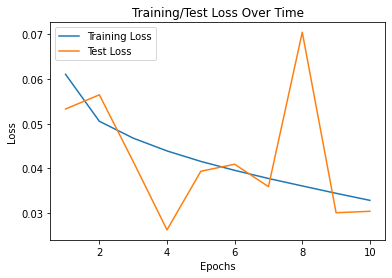

In [ ]:
import matplotlib.pyplot as plt
 
x  = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
plt.plot(x, train_losses, label="Training Loss")
plt.plot(x, test_losses, label="Test Loss")
plt.plot()

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training/Test Loss Over Time")
plt.legend()
plt.show()

In [ ]:
# Use this function to compute your model accuracy!
# Note that the dataloader argument can take trainloader or testloader
def compute_accuracy(model, dataloader):
    correct = 0
    total = 0
    model.train(False)
    with torch.no_grad():
        for data in dataloader:
            xs, ys = data
            xs = xs.to(device)
            ys = ys.to(device)
            y_preds = model(xs)
            _, predicted = torch.max(y_preds.data, 1)
            total += ys.size(0)
            # print(ys)
            # print(ys.cpu().detach().numpy())
            correct += (predicted == ys).sum().item()
    print('Model accuracy: %d %%' % (100 * correct / total))
  
compute_accuracy(model, trainloader)
compute_accuracy(model, testloader)

Model accuracy: 67 %
Model accuracy: 54 %


Model precision for class 0 through 9, respectively: [0.70503876 0.81568228 0.53122172 0.60341151 0.60975104 0.54714384
 0.69519833 0.6999824  0.78943073 0.75186056]
Model recall for class 0 through 9, respectively: [0.7276 0.801  0.587  0.3396 0.5878 0.636  0.7326 0.7956 0.7738 0.7678]
Confusion_matrix: [[0.70503876 0.02464358 0.0441629  0.02203269 0.03298755 0.01118376
  0.01233631 0.02005983 0.06794532 0.03897376]
 [0.0248062  0.81568228 0.01031674 0.01385928 0.00788382 0.00688231
  0.01138736 0.00967799 0.03631912 0.07833921]
 [0.05949612 0.00631365 0.53122172 0.05721393 0.10995851 0.0583276
  0.06187132 0.04275911 0.01183432 0.01370936]
 [0.01918605 0.00916497 0.08886878 0.60341151 0.04979253 0.23554714
  0.09413551 0.0538448  0.02305652 0.02800627]
 [0.04534884 0.00325866 0.1241629  0.0376688  0.60975104 0.03716449
  0.04744733 0.07179307 0.0173434  0.01175088]
 [0.00813953 0.00509165 0.0761991  0.14072495 0.04460581 0.54714384
  0.04706775 0.0610593  0.01244644 0.01273012]
 [0.0

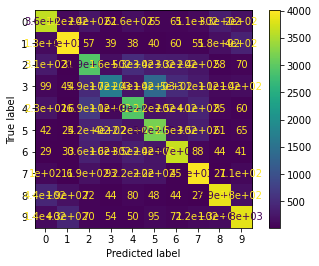

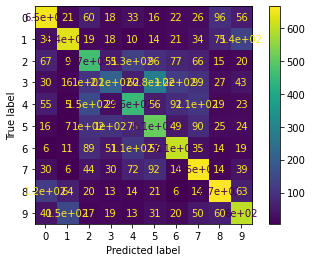

In [ ]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

def compute_precision_recall(model, dataloader):
    correct = 0
    total = 0
    model.train(False)
    preds = []
    y = np.array([])
    x = np.array([])
    with torch.no_grad():
        for data in dataloader:
            xs, ys = data
            xs = xs.to(device)
            ys = ys.to(device)
            y = np.append(y, ys.cpu().detach().numpy())
            x = np.append(x, xs.cpu().detach().numpy())
            y_preds = model(xs)
            _, predicted = torch.max(y_preds.data, 1)
            preds = np.append(preds, predicted.cpu().detach().numpy())
            total += ys.size(0)
            correct += (predicted == ys).sum().item()
    # print(preds)
    # print(y)
    prec_recall = precision_recall_fscore_support(y, preds, average=None, labels=list(range(10)))
    acc = accuracy_score(y, preds)
    # print(prec_recall)
    # print('Model accuracy:', acc)
    print('Model precision for class 0 through 9, respectively:', prec_recall[0])
    print('Model recall for class 0 through 9, respectively:', prec_recall[1])
    arr = confusion_matrix(y, preds)
    print("Confusion_matrix:", arr / sum(arr))
    disp = ConfusionMatrixDisplay(confusion_matrix=arr, display_labels=list(range(10)))
    disp.plot() 
    # df_cm = pd.DataFrame(arr, index = list(range(10)),
    #               columns = list(range(10)))
    # plt.figure(figsize = (10,7))
    # sn.heatmap(df_cm, annot=True)
    # plot_confusion_matrix(model, x, y, normalize=all)  
    # plt.show()


  
compute_precision_recall(model, trainloader)
compute_precision_recall(model, testloader)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

class Part2NeuralNetwork(nn.Module):
    def __init__(self):
        super(Part2NeuralNetwork, self).__init__()
        self.fc1 = torch.nn.Linear(3072, 2000) 
        self.fc2 = torch.nn.Linear(2000, 2000) 
        self.fc3 = torch.nn.Linear(2000, 2000) 
        self.fc4 = torch.nn.Linear(2000, 2000) 
        self.fc5 = torch.nn.Linear(2000, 2000) 
        self.fc6 = torch.nn.Linear(2000, 10) 
        ## TODO: Define your neural network layers here!
        ## Importantly, any modules which initialize weights should be initialized
        ## as member variables here. 
        ## Note: Keep track of the shape of your input tensors in the training
        ## and test sets, because it affects how you define your layers!
        ## You might find this resource helpful:
        ## https://towardsdatascience.com/pytorch-layer-dimensions-what-sizes-should-they-be-and-why-4265a41e01fd

    def forward(self, x):
        ## TODO: This is where you should apply the layers defined in the __init__
        ## method and the ReLU activation functions to the input x.
        self.batch_size = x.shape[0]
        x = x.view(self.batch_size, -1)
        # self.flatten_dim = x.shape[1]*x.shape[2]*x.shape[3]
        # print(x.shape)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = F.relu(self.fc6(x))
        return x

# Display model architecture
model = Part2NeuralNetwork()
model.to(device)

Part2NeuralNetwork(
  (fc1): Linear(in_features=3072, out_features=2000, bias=True)
  (fc2): Linear(in_features=2000, out_features=2000, bias=True)
  (fc3): Linear(in_features=2000, out_features=2000, bias=True)
  (fc4): Linear(in_features=2000, out_features=2000, bias=True)
  (fc5): Linear(in_features=2000, out_features=2000, bias=True)
  (fc6): Linear(in_features=2000, out_features=10, bias=True)
)

In [ ]:
# TODO - Complete NN training

# Reinitialize to ensure we are training a new model
model = Part2NeuralNetwork()
model.to(device)

loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

train_losses = []
test_losses = []

for epoch in range(10):
    running_loss = 0.0
    model.train(True)
    for i, data in enumerate(trainloader, 0):
        # Get inputs; data is a list of [inputs, labels]
        xs, ys = data
        xs = xs.to(device)
        ys = ys.to(device)

        ## TODO: optimize model parameters

        # forward
        y_pred = model(xs)
        loss = loss_function(y_pred, ys)

        optimizer.zero_grad()
        
        #backward
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    train_losses.append(running_loss / 50000)
    print('[Epoch %d] average train loss: %.3f' % (epoch + 1, running_loss / 50000))
    
    model.train(False)
    running_test_loss = 0.0
    ## TODO: calculate test loss in similar fashion

    for i, data in enumerate(testloader, 0):
        # Get inputs; data is a list of [inputs, labels]
        xs, ys = data
        xs = xs.to(device)
        ys = ys.to(device)
        running_test_loss += loss.item()

    test_losses.append(running_test_loss / 10000)
    print('[Epoch %d] average test loss: %.3f' % (epoch + 1, running_test_loss / 10000))

print('Finished Training')

[Epoch 1] average train loss: 0.072
[Epoch 1] average test loss: 0.072
[Epoch 2] average train loss: 0.070
[Epoch 2] average test loss: 0.066
[Epoch 3] average train loss: 0.061
[Epoch 3] average test loss: 0.058
[Epoch 4] average train loss: 0.053
[Epoch 4] average test loss: 0.055
[Epoch 5] average train loss: 0.048
[Epoch 5] average test loss: 0.035
[Epoch 6] average train loss: 0.045
[Epoch 6] average test loss: 0.044
[Epoch 7] average train loss: 0.042
[Epoch 7] average test loss: 0.040
[Epoch 8] average train loss: 0.039
[Epoch 8] average test loss: 0.033
[Epoch 9] average train loss: 0.037
[Epoch 9] average test loss: 0.043
[Epoch 10] average train loss: 0.035
[Epoch 10] average test loss: 0.033
Finished Training


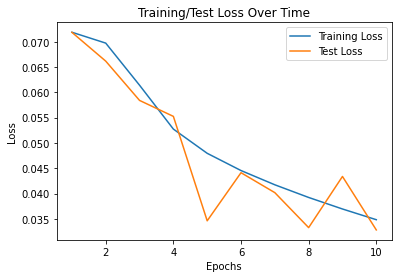

In [ ]:
import matplotlib.pyplot as plt
 
x  = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
plt.plot(x, train_losses, label="Training Loss")
plt.plot(x, test_losses, label="Test Loss")
plt.plot()

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training/Test Loss Over Time")
plt.legend()
plt.show()

Model accuracy: 64 %
Model accuracy: 53 %
Model precision for class 0 through 9, respectively: [0.69671653 0.76795367 0.59251031 0.42045099 0.54684299 0.51610954
 0.61956354 0.82261072 0.75475285 0.8591029 ]
Model recall for class 0 through 9, respectively: [0.7172 0.7956 0.3734 0.537  0.5872 0.5126 0.8006 0.7058 0.794  0.6512]
Confusion_matrix: [[6.96716534e-01 1.89189189e-02 8.02919708e-02 2.89696210e-02
  3.87409201e-02 1.00684656e-02 8.35783934e-03 1.35198135e-02
  8.51711027e-02 1.58311346e-02]
 [3.90518749e-02 7.67953668e-01 3.17359568e-04 1.65988099e-02
  4.65636059e-03 3.02053967e-03 9.75081257e-03 3.49650350e-03
  6.27376426e-02 7.01846966e-02]
 [5.65377890e-02 3.28185328e-03 5.92510314e-01 8.83181961e-02
  1.85695660e-01 8.73942811e-02 9.61151525e-02 3.24009324e-02
  9.88593156e-03 4.74934037e-03]
 [1.32115796e-02 6.56370656e-03 5.71247223e-02 4.20450987e-01
  3.66921214e-02 2.11639146e-01 9.56508280e-02 1.84149184e-02
  1.15969582e-02 7.12401055e-03]
 [4.27433456e-02 4.05405

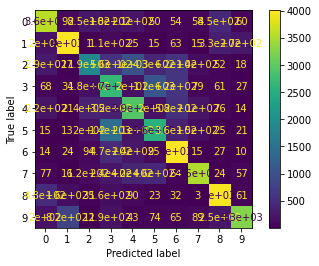

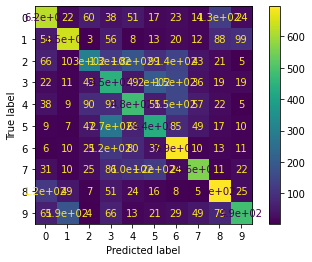

In [ ]:
compute_accuracy(model, trainloader)
compute_accuracy(model, testloader)
compute_precision_recall(model, trainloader)
compute_precision_recall(model, testloader)

<a name="Appendix"></a>
# Appendix: Computation Graphs

A *computation graph* is an abstract graphical representation of a mathematical expression involving variables. Each variable is represented as an edge, and each operation as a node; the graph is directed and acyclic. For instance, the expression $(x + y)^2 + x$ can be represented as:

![Computation Graph](https://github.com/harvard-ml-courses/cs181-s21-homeworks/blob/main/hw3/T3_P3_computation_graph.jpg?raw=true)

Expressions can be converted into graphs and vice versa. Computation graphs are useful representations in the context of neural networks, because
1. They encode all the necessary information for the computation of gradients into discrete units through repeated application of the chain rule, and
2. Graphs are easy to implement with code (conceptually, one can imagine storing pointers between nodes)

The process in step #1 is known as *automatic differentiation*.

If you would like to walk through a computation graph on a small neural network, we recommend [this resource](https://blog.paperspace.com/pytorch-101-understanding-graphs-and-automatic-differentiation/).

# Appendix: Convolutional Neural Networks

A convolutional neural network (CNN) is a special type of neural network that has "convolution layers". CNNs are able to model spatial and temporal dependencies in ordered sequences of input data.

The convolution layer of a CNN applies a filter (sometimes referred to as a "kernel") to an input to produce an output. 

Assume without loss of generality that we have two-dimensional input data $x : m \times n$.  For example, $x$ may be the color of each pixel of a grayscale $m$ by $n$ image.

During the forward pass, we slide (or "convolve") the filter across the input data.  In most CNNs, the filter is a function of "regions" of the data, where individual components of the input are grouped together.  For example, a convolutional filter applied to image data may take into account $3 x 3$ groups of pixels to model dependencies in between adjacent pixels:

![CNN sliding window](https://courses.edx.org/assets/courseware/v1/7396a332c596cb606eae215d96301334/asset-v1:MITx+6.871Jx+2T2021+type@asset+block/cnn_sliding_window.gif)

This GIF image shows a sliding convolutional 3 x 3 filter, being applied to 3 x 3 segments of a 4 x 4 dataset.

source: https://towardsdatascience.com/intuitively-understanding-convolutions-for-deep-learning-1f6f42faee1

Another example of a 1-dimensional convolution filter is illustrated by the below GIF:

![Convolution operation for a simple (1 x 3) filter](https://studio.edx.org/assets/courseware/v1/20da14e015eac1863451dafe3d456e59/asset-v1:MITx+6.871Jx+2T2021+type@asset+block/cnn.gif)

This animation is described below.

In this example, the filter $[2, 3, 1]$ is applied as an inner product with the input vector $x = [x_1, x_2, ..., x_{10}]: 1 \times 10$ which contains annotations of a patient EKG.  Notice here that the filter is applied to 3 successive time-steps of the input vector: the output $y_t$ at time $t$ is equal to $[2, 3, 1] \cdot [x_t, x_{t + 1}, t_{t + 2}]$.  Therefore the output $y_t$ contains information not only about a single EKG annotation $x_t$, but also about nearby EKG annotations $x_{t + 1}$ and $x_{t + 2}$.

We strongly recommend [reading this article](https://adventuresinmachinelearning.com/convolutional-neural-networks-tutorial-in-pytorch/) which walks through how to create a CNN using conv and pooling layers in PyTorch.

If you are interested, you can also watch this [MIT lecture](https://www.youtube.com/watch?v=iaSUYvmCekI) on CNNs.